In [61]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [43]:
# Constants
IMAGE_DIR = "../Data/raw/images"
MASK_DIR = "../Data/raw/masks"
BATCH_SIZE = 8
PATCH_SIZE = (512, 512)
NUM_CLASSES = 2  # Background + Flood
LEARNING_RATE = 0.001
NUM_EPOCHS = 20

In [3]:
# Seed for reproducibility
torch.manual_seed(42)

In [63]:

class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None, augmentations=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.augmentations = augmentations
        
        self.image_paths = sorted(os.listdir(image_dir))
        self.mask_paths = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_paths[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") 

       
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [64]:
image_transform = transforms.Compose([
    transforms.Resize(size=PATCH_SIZE, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=PATCH_SIZE, antialias=False)
])

train_augmentations = transforms.Compose([
    transforms.RandomVerticalFlip(),
])

In [66]:
# Create dataset
dataset = CustomDataset(IMAGE_DIR, MASK_DIR,image_transform=image_transform, mask_transform=mask_transform)
list(dataset)

[(tensor([[[0.2471, 0.2353, 0.1961,  ..., 0.0980, 0.0784, 0.1686],
           [0.2431, 0.2196, 0.1804,  ..., 0.0980, 0.0784, 0.1804],
           [0.2431, 0.2275, 0.1882,  ..., 0.1098, 0.0902, 0.1804],
           ...,
           [0.1176, 0.1137, 0.0863,  ..., 0.7922, 0.7922, 0.8431],
           [0.0863, 0.0863, 0.0824,  ..., 0.8000, 0.7961, 0.8353],
           [0.4902, 0.5176, 0.4863,  ..., 0.8824, 0.8863, 0.9137]],
  
          [[0.3137, 0.3098, 0.2745,  ..., 0.1647, 0.1412, 0.2235],
           [0.3137, 0.3020, 0.2667,  ..., 0.1647, 0.1412, 0.2275],
           [0.3216, 0.3098, 0.2706,  ..., 0.1765, 0.1529, 0.2392],
           ...,
           [0.1451, 0.1451, 0.1490,  ..., 0.7922, 0.7922, 0.8314],
           [0.1451, 0.1451, 0.1451,  ..., 0.8118, 0.8000, 0.8392],
           [0.5255, 0.5412, 0.5216,  ..., 0.8980, 0.8980, 0.9137]],
  
          [[0.2863, 0.2863, 0.2471,  ..., 0.1569, 0.1333, 0.2235],
           [0.3059, 0.2588, 0.2392,  ..., 0.1569, 0.1333, 0.2471],
           [0.2980, 0.

In [67]:
# Define the sizes for each split
dataset_size = len(dataset)
test_size = int(0.15 * dataset_size)
val_size  = int(0.15 * dataset_size)
train_size = dataset_size - test_size - val_size

In [70]:
dataset_size,test_size,val_size,train_size

(290, 43, 43, 204)

In [71]:
# Use random_split to create train, test, and val datasets
train_dataset, temp_dataset = random_split(dataset, [train_size, test_size + val_size], generator=torch.Generator().manual_seed(42))
test_dataset, val_dataset = random_split(temp_dataset, [test_size, val_size], generator=torch.Generator().manual_seed(42))

train_dataset.augmentations = train_augmentations

# Create DataLoader instances for each set
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

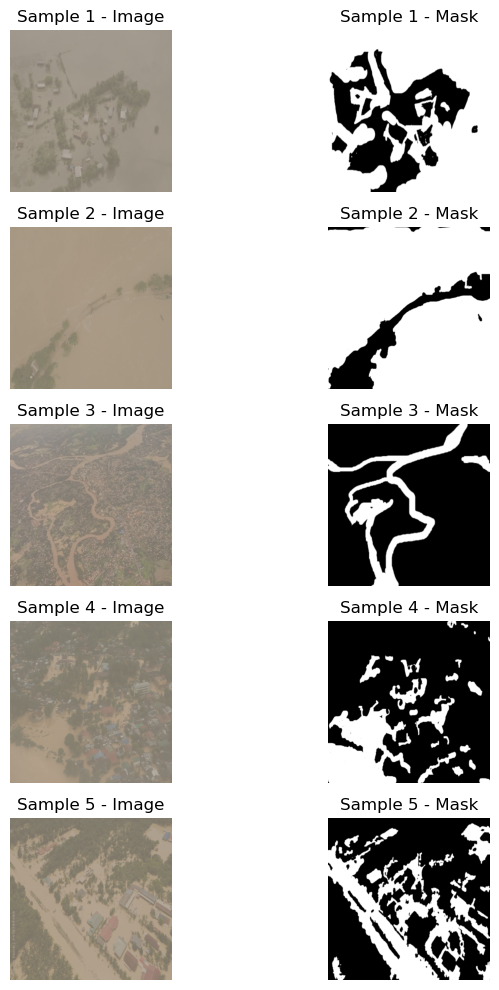

In [72]:
# Function to denormalize images
def denormalize_tensor(image, mean = (0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return image

# Function to visualize images and masks
def visualize_samples(dataset, num_samples=5):
    # Visualize the images and masks
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2 * num_samples))
    for i in range(num_samples):
        image, mask = dataset[np.random.randint(len(dataset))]
        
        # Display images
        axes[i, 0].imshow(denormalize_tensor(image).cpu().permute(1,2,0))
        axes[i, 0].set_title(f'Sample {i + 1} - Image')
        axes[i, 0].axis('off')

        # Display masks
        axes[i, 1].imshow(mask.cpu().squeeze(), cmap='gray')
        axes[i, 1].set_title(f'Sample {i + 1} - Mask')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples from the train dataset
visualize_samples(train_dataset)

In [73]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [75]:
list(train_loader)

[((tensor([[[0.5569, 0.5569, 0.5569,  ..., 0.5647, 0.5647, 0.5647],
            [0.5569, 0.5569, 0.5569,  ..., 0.5647, 0.5647, 0.5647],
            [0.5569, 0.5569, 0.5569,  ..., 0.5647, 0.5647, 0.5647],
            ...,
            [0.5412, 0.5333, 0.5294,  ..., 0.5412, 0.5412, 0.5412],
            [0.5451, 0.5373, 0.5255,  ..., 0.5412, 0.5412, 0.5412],
            [0.5490, 0.5373, 0.5255,  ..., 0.5412, 0.5412, 0.5412]],
   
           [[0.5608, 0.5608, 0.5608,  ..., 0.5686, 0.5686, 0.5686],
            [0.5608, 0.5608, 0.5608,  ..., 0.5686, 0.5686, 0.5686],
            [0.5608, 0.5608, 0.5608,  ..., 0.5686, 0.5686, 0.5686],
            ...,
            [0.5020, 0.4941, 0.4902,  ..., 0.5216, 0.5216, 0.5216],
            [0.5059, 0.4980, 0.4863,  ..., 0.5216, 0.5216, 0.5216],
            [0.5098, 0.4980, 0.4863,  ..., 0.5216, 0.5216, 0.5216]],
   
           [[0.6392, 0.6392, 0.6392,  ..., 0.6471, 0.6471, 0.6471],
            [0.6392, 0.6392, 0.6392,  ..., 0.6471, 0.6471, 0.6471],
    

In [76]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

D:\Technion\envs\TechnionAiProg\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Technion\envs\TechnionAiProg\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [78]:
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# Move model to the appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in